In [1]:
__author__ = "Philipp Kats"
__date__ = "2015_10_13"

import pandas as pd
import numpy as np

import pylab as plt
import os
import json

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import geopandas as gp
from geopandas.tools import sjoin

In [3]:
parqa = os.getenv('PARQA') #basic path

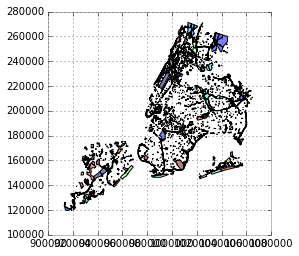

In [4]:
parks = gp.read_file(parqa + 'data/DPR_ParksProperties_001/DPR_ParksProperties_001.shp')
parks.plot();

In [5]:
parks.head(2)

,BOROUGH,GISPROPNUM,LOCATION,NYS_ASSEMB,NYS_SENATE,SHAPE_STAr,SHAPE_STLe,SIGNNAME,TYPECATEGO,US_CONGRES,WATERFRONT,geometry
0,Q,Q104,"Queensboro Bridge, 41 Rd., 40 Ave. bet. The Ea...",37,12,903579.125015,7376.271660,Queensbridge Park,Community Park,12,Yes,"(POLYGON ((998639.7287544757 214672.844326064,..."
1,X,X253,City Island Ave bet. Centre St. and Winter St.,82,34,263831.264191,2635.610175,Ambrosini Field,Recreation Field/Courts,14,Yes,"POLYGON ((1044445.201119721 246876.5331993997,..."


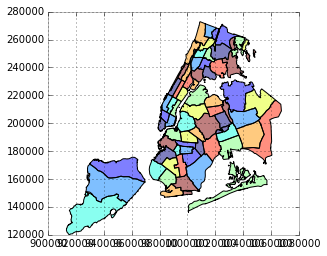

In [6]:
pDistricts = gp.read_file(parqa + 'data/shp/ParkDistrict.shp')
pDistricts.plot();

In [7]:
print len(pDistricts)
pDistricts.head(2)

71


,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,..."
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ..."


In [8]:
pDistricts.BOROUGH.value_counts()

B    19
M    17
X    16
Q    16
R     3
Name: BOROUGH, dtype: int64

## I. Check and cure projections

In [9]:
parks.crs

{u'ellps': u'GRS80',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'towgs84': u'0,0,0,0,0,0,0',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

In [10]:
pDistricts.crs

{u'ellps': u'GRS80',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'towgs84': u'0,0,0,0,0,0,0',
 u'units': u'us-ft',
 u'x_0': 300000.0000000001,
 u'y_0': 0}

In [13]:
# parks.to_crs(epsg=4236, inplace=True)
# pDistricts.to_crs(epsg=4236, inplace=True) - nice to have but completely wrong for areas and distances in shapely

crs = parks.crs
pDistricts.to_crs(crs,inplace=True)

## II. Define District for each park

In [14]:
parks['park_area'] = parks.geometry.area   #save area as non-system column

In [15]:
Cparks = parks.copy()
Cparks['geometry'] = Cparks.centroid
Cparks.head(2)


,BOROUGH,GISPROPNUM,LOCATION,NYS_ASSEMB,NYS_SENATE,SHAPE_STAr,SHAPE_STLe,SIGNNAME,TYPECATEGO,US_CONGRES,WATERFRONT,geometry,park_area
0,Q,Q104,"Queensboro Bridge, 41 Rd., 40 Ave. bet. The Ea...",37,12,903579.125015,7376.271660,Queensbridge Park,Community Park,12,Yes,POINT (998605.1065955567 214637.5474135593),903579.125068
1,X,X253,City Island Ave bet. Centre St. and Winter St.,82,34,263831.264191,2635.610175,Ambrosini Field,Recreation Field/Courts,14,Yes,POINT (1044180.735226439 247025.9500432702),263831.264211


In [16]:
parkB = sjoin(Cparks, pDistricts, how="left")
len(parkB)

2001

In [17]:
len(parks)

2001

In [19]:
pdf = parkB.groupby('SYSTEM', as_index=False).agg({'park_area':np.sum, 'GISPROPNUM': lambda x: list(x)})
pdf['num'] = pdf.GISPROPNUM.apply(len)

In [20]:
print len(pdf)
pdf.head(5)

68


,SYSTEM,GISPROPNUM,park_area,num
0,B-01,"[B529, B223R, B223U, B085, B223QB, B223QC, B22...",4717775.085389,73
1,B-02,"[B021, B253, B223DJ, B223DH, B223DI, B223E, B2...",5315899.801310,59
2,B-03,"[B038, B398, B474, B294, B302, B317, B403, B02...",2577186.017167,67
3,B-04,"[B016, B017, B045, B307, B332, B334, B340, B38...",1150847.596176,21
4,B-05,"[B078, B214, B261, B290, B383, B163, B047A, B0...",8484231.436543,71


In [21]:
pD2 = pDistricts.merge(pdf, on='SYSTEM', how="left")

In [22]:
pD2.head(3)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,GISPROPNUM,park_area,num
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722159 195771.7118526875,...","[M308, M366, M013, M242, M291, M030, M386, M38...",1885072.944385,22
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133854 203852.9256771017,...","[M125A, M125B, M125E, M120A, M125C, M276, M038...",882310.088034,34
2,None,M,104,"3, 6",48977247.921813,61207.299629,M-04,"POLYGON ((981583.9111601406 209954.3750883674,...","[M154, M066, M022, M011, M161, M221, M249, M25...",851900.177139,14


In [23]:
pD2['park_ratio']=pD2.park_area/pD2.SHAPE_Area

In [24]:
pD2.head(2)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry,GISPROPNUM,park_area,num,park_ratio
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722159 195771.7118526875,...","[M308, M366, M013, M242, M291, M030, M386, M38...",1885072.944385,22,0.057134
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133854 203852.9256771017,...","[M125A, M125B, M125E, M120A, M125C, M276, M038...",882310.088034,34,0.023414


## Saving data

### I. Districts

In [25]:
pD2.to_csv(parqa + 'data/park_Districts_computed.csv')


In [26]:
def writeJson(df,path):
    '''writes df as json'''
    with open(path,'w') as jsFile:
        jsFile.write(df.to_json())
    

In [27]:
writeJson(pD2, parqa + 'data/park_Districts_computed.geojson')

### II. Parks with district attribute

In [28]:
parksD = parks.merge(parkB[['GISPROPNUM','SYSTEM']], on='GISPROPNUM', how='left')

In [29]:
parksD.rename(columns={'SYSTEM':'Park_District'}, inplace=True)


In [30]:
writeJson(parksD, parqa + 'data/parks_computed.geojson')